Name: Hendra<br>
Email: hendradrakho@gmail.com<br>
Runtime: Google Colab Local Runtime<br>
CPU: AMD Ryzen 5 7640hs<br>
GPU: Nvidia RTX 4060 Mobile<br>

In [1]:
!pip install google-play-scraper

In [2]:
!pip install textblob

In [3]:
!pip install kagglehub

In [4]:
!pip install nltk spacy

In [5]:
!pip install wordcloud

In [6]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
# Using Local Runtime (Google-Drive) Not Supported
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [9]:
cd Dicoding-Machine-Learning

/content/drive/MyDrive/Dicoding-Machine-Learning


In [10]:
cd SentimentAnalysisSubmission2025

/content/drive/MyDrive/Dicoding-Machine-Learning/SentimentAnalysisSubmission2025


In [11]:
mkdir -p notebook

In [12]:
!pip freeze > requirements.txt

# Preprocessing

In [13]:
# Config
datasetDir = 'dataset/'
gloveDir = 'glove/'

rawDatasetName = 'googleplay_minecraft_US_reviews_raw.csv'
lemmatizeDatasetName = 'googleplay_minecraft_US_reviews_lemmatize.csv'
prepDatasetName = 'googleplay_minecraft_US_reviews_preprocessed.csv'
balanceDatasetName = 'googleplay_minecraft_US_reviews_balance.csv'
gloveName = 'glove.6B.100d.txt'

dataset = datasetDir + rawDatasetName

prep_dataset = datasetDir + prepDatasetName
balance_dataset = datasetDir + balanceDatasetName
lemmatize_save = datasetDir + lemmatizeDatasetName
glove_file = gloveDir + gloveName

In [14]:
# Function to Analize Sentiment

def analizeSentiment(text):
    prediction = TextBlob(text)
    polarity = prediction.sentiment.polarity

    if polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    return 'negative'

In [15]:
# Function to filter dataset

def filterDataset(reviews_df):
  df = reviews_df

  # Remove Emoji or other data who not text
  df['content'] = df['content'].astype(str).replace('nan', '', regex=True)
  df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
  df['content'] = df['content'].apply(lambda x: ''.join(char for char in x if char.isalnum() or char.isspace()))

  print('Total Null Values:', reviews_df.isnull().sum().sum())
  print('Total Duplicated Values:', reviews_df.duplicated().sum())

  df = df.dropna(subset=['content'])
  df = df.drop_duplicates(subset=['content'])
  df = df.reset_index(drop=True)

  print('Total Null Values After Filter:', df.isnull().sum().sum())
  print('Total Duplicated Values After Filter:', df.duplicated().sum())
  return df

In [16]:
def balancing_dataset(df):
  # Drop null and duplicated value
  df['text_lemmatized'] = df['text_lemmatized'].astype(str).replace('nan', '', regex=True)
  print('label distribution before dropped:', df["label"].value_counts())
  drop_duplicate_df = df.drop_duplicates(subset=['text_lemmatized'])
  print('label distribution after dropped:', df["label"].value_counts())

  # Delete sentences with less than 6 words from the 'text_lemmatized' column
  filtered_reviews_df = drop_duplicate_df[drop_duplicate_df['text_lemmatized'].apply(lambda x: len(x.split()) >= 5)]


  label_counts = filtered_reviews_df["label"].value_counts()

  max_label = label_counts.idxmax()
  max_second_label = label_counts.iloc[1]
  max_label_rows = filtered_reviews_df[filtered_reviews_df["label"] == max_label]

  drop_count = len(max_label_rows) - max_second_label

  print(label_counts)
  print("qty 1st label:", max_label)
  print("qty 2st label:", max_second_label)
  print("qty label Dropped:", drop_count)

  if drop_count > 0:
      filtered_reviews_df = filtered_reviews_df.drop(max_label_rows.sample(n=drop_count, random_state=42).index)

  return filtered_reviews_df

In [17]:
# Function to extract a zip file or copy a directory to the target directory
import zipfile as zf
import os
import shutil

def extract_or_copy(source_path, target_directory):
    try:
        os.makedirs(target_directory, exist_ok=True)

        if source_path.endswith('.zip'):
            with zf.ZipFile(source_path, 'r') as zip_file:
                zip_file.extractall(target_directory)
                print('Extraction completed successfully.')
        elif os.path.isdir(source_path):
            shutil.copytree(source_path, target_directory, dirs_exist_ok=True)
            print('Directory copied successfully.')
        else:
            print('Source is neither a .zip file nor a directory.')

    except FileNotFoundError:
        print(f"Source path '{source_path}' not found.")
    except PermissionError:
        print(f"Permission denied while accessing '{source_path}' or '{target_directory}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        print('End the process.')

In [18]:
# Split Text for lemmatization

def split_words(text):
  if isinstance(text, str):
    return text.split()
  print('Anomaly Detected, values:', text)
  return ''

In [19]:
# Line chart to Plot Training accuracy and loss

import datetime
import matplotlib.pyplot as plt

def plot_training_model(histSave):
  acc = histSave.history['accuracy']
  epoch = range(len(acc))
  val_acc = histSave.history['val_accuracy']
  val_loss = histSave.history['val_loss']
  loss = histSave.history['loss']

  plt.figure(figsize = (15,5))
  plt.plot(epoch, acc, label='Training Accuracy')
  plt.plot(epoch, loss, label='Training Loss')
  plt.plot(epoch, val_acc, label='validation Acurracy')
  plt.plot(epoch, val_loss, label='validation Loss')
  plt.title('Plot Accuracy')
  plt.xlabel('Accuracy')
  plt.ylabel('Epoch')
  plt.legend()
  plt.show()

In [20]:
# Visualize Dataset with Wordcloud

from wordcloud import WordCloud

def visualize_word_cloud(df, option='All'):
    list_words = ''

    for review in df['text_stopwords']:
        for word in review:
            list_words += ' ' + (word)

    # Plot with WordCloud
    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'Word Cloud of {option} Reviews Data', fontsize=18)
    ax.grid(False)
    ax.imshow((wordcloud))
    fig.tight_layout(pad=0)
    ax.axis('off')
    plt.show()

In [21]:
# Visualize Dataset Distribution

def pie_chart(dataset):
  label_counts = dataset["label"].value_counts()

  # Plot pie chart
  plt.figure(figsize=(6, 6))
  plt.pie(label_counts, labels=label_counts.index, autopct="%.1f%%", startangle=140, colors=["red", "green", "yellow"])
  plt.title("Class Distribution")
  plt.show()

In [22]:
import kagglehub
if not os.path.exists(glove_file):
  glovePath = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")
  extract_or_copy(glovePath, gloveDir)
else:
  print('File Glove Already Exist')

File Glove Already Exist


In [23]:
# Download NLTK Resouce
import nltk

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
import string
import spacy
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
list_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset Cleaning

In [25]:
# Read Raw Dataset
import pandas as pd

raw_df = pd.read_csv(dataset)
raw_df.head()

,content
0,"It's okay, better on pc though"
1,IT WONT LET ME DOWNLOAD IT!
2,I love this game soo much but i want Minecraft...
3,"This game is very fun, ive had it for a while ..."
4,Best game ever! I had a great experience. Also...


In [26]:
filter_df = filterDataset(raw_df)
filter_df.head()

Total Null Values: 0
Total Duplicated Values: 3458
Total Null Values After Filter: 0
Total Duplicated Values After Filter: 0


,content
0,Its okay better on pc though
1,IT WONT LET ME DOWNLOAD IT
2,I love this game soo much but i want Minecraft...
3,This game is very fun ive had it for a while a...
4,Best game ever I had a great experience Also I...


In [27]:
# Dataset Cleaning
def cleaning(text):
    if str(text) == 'nan':
      print('Anomaly Detected, dropped values:', text)
      return ''

    text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())
    text = text.replace("http://", " ").replace("https://", " ")
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    return text

# Tokenize
def word_tokenize_wrapper(text):
    if str(text) == 'nan':
      print('Anomaly Detected, dropped values:', text)
      return ''

    return word_tokenize(text)

# Stopword Removal
def stopwords_removal(words):
    return [word for word in words if word.lower() not in list_stopwords]

In [28]:
# Case Folding
filter_df['content'] = filter_df['content'].str.lower()
filter_df.head()

,content
0,its okay better on pc though
1,it wont let me download it
2,i love this game soo much but i want minecraft...
3,this game is very fun ive had it for a while a...
4,best game ever i had a great experience also i...


In [29]:
# Text Cleaning
filter_df['text_cleaning'] = filter_df['content'].apply(cleaning)
filter_df.head()

,content,text_cleaning
0,its okay better on pc though,its okay better on pc though
1,it wont let me download it,it wont let me download it
2,i love this game soo much but i want minecraft...,love this game soo much but want minecraft t...
3,this game is very fun ive had it for a while a...,this game is very fun ive had it for while an...
4,best game ever i had a great experience also i...,best game ever had great experience also lo...


### Preprocessing Dataset

In [30]:
# lemmatizing function to Text
def spacy_lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

In [31]:
# Reading Clean Dataset
clean_df = filter_df
clean_df.head()

,content,text_cleaning
0,its okay better on pc though,its okay better on pc though
1,it wont let me download it,it wont let me download it
2,i love this game soo much but i want minecraft...,love this game soo much but want minecraft t...
3,this game is very fun ive had it for a while a...,this game is very fun ive had it for while an...
4,best game ever i had a great experience also i...,best game ever had great experience also lo...


In [32]:
clean_df = clean_df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [33]:
# Word Tokonize Wrapper
clean_df['text_tokens'] = clean_df['text_cleaning'].apply(word_tokenize_wrapper)
clean_df.head()

,content,text_cleaning,text_tokens
0,its okay better on pc though,its okay better on pc though,"[its, okay, better, on, pc, though]"
1,it wont let me download it,it wont let me download it,"[it, wont, let, me, download, it]"
2,i love this game soo much but i want minecraft...,love this game soo much but want minecraft to...,"[love, this, game, soo, much, but, want, minec..."
3,this game is very fun ive had it for a while a...,this game is very fun ive had it for while an...,"[this, game, is, very, fun, ive, had, it, for,..."
4,best game ever i had a great experience also i...,best game ever had great experience also lo...,"[best, game, ever, had, great, experience, als..."


In [34]:
# Remove Stopword
clean_df['text_stopwords'] = clean_df['text_tokens'].apply(stopwords_removal)
clean_df.head()

,content,text_cleaning,text_tokens,text_stopwords
0,its okay better on pc though,its okay better on pc though,"[its, okay, better, on, pc, though]","[okay, better, pc, though]"
1,it wont let me download it,it wont let me download it,"[it, wont, let, me, download, it]","[wont, let, download]"
2,i love this game soo much but i want minecraft...,love this game soo much but want minecraft to...,"[love, this, game, soo, much, but, want, minec...","[love, game, soo, much, want, minecraft, creat..."
3,this game is very fun ive had it for a while a...,this game is very fun ive had it for while an...,"[this, game, is, very, fun, ive, had, it, for,...","[game, fun, ive, even, though, gets, boring, s..."
4,best game ever i had a great experience also i...,best game ever had great experience also lo...,"[best, game, ever, had, great, experience, als...","[best, game, ever, great, experience, also, lo..."


In [35]:
# lemmatize text
clean_df['text_lemmatized'] = clean_df['text_stopwords'].apply(spacy_lemmatize)
clean_df = clean_df.drop_duplicates(subset=['text_lemmatized'])
clean_df.head()

,content,text_cleaning,text_tokens,text_stopwords,text_lemmatized
0,its okay better on pc though,its okay better on pc though,"[its, okay, better, on, pc, though]","[okay, better, pc, though]","[okay, well, pc, though]"
1,it wont let me download it,it wont let me download it,"[it, wont, let, me, download, it]","[wont, let, download]","[will, not, let, download]"
2,i love this game soo much but i want minecraft...,love this game soo much but want minecraft to...,"[love, this, game, soo, much, but, want, minec...","[love, game, soo, much, want, minecraft, creat...","[love, game, soo, much, want, minecraft, creat..."
3,this game is very fun ive had it for a while a...,this game is very fun ive had it for while an...,"[this, game, is, very, fun, ive, had, it, for,...","[game, fun, ive, even, though, gets, boring, s...","[game, fun, I, ve, even, though, get, boring, ..."
4,best game ever i had a great experience also i...,best game ever had great experience also lo...,"[best, game, ever, had, great, experience, als...","[best, game, ever, great, experience, also, lo...","[good, game, ever, great, experience, also, lo..."


In [36]:
# Save Lemmatize Dataset
clean_df.reset_index(drop=True, inplace=True)
clean_df.to_csv(lemmatize_save, index=False, encoding='utf-8')

Lemmatized used because if you use stemming there are some words that should not be affected by the stemming effect, the words actually have fewer letters.

### Labeling

In [37]:
# assign preprocessing dataset
import pandas as pd
from textblob import TextBlob
pd.options.mode.copy_on_write = True

df = pd.read_csv(lemmatize_save)

# Restore Arrays
columns_recovery = ['text_tokens', 'text_stopwords', 'text_lemmatized']
for col in columns_recovery:
    df[col] = df[col].astype(str).str.strip("[]").str.replace("'", "").str.split(", ")

df.head()

,content,text_cleaning,text_tokens,text_stopwords,text_lemmatized
0,its okay better on pc though,its okay better on pc though,"[its, okay, better, on, pc, though]","[okay, better, pc, though]","[okay, well, pc, though]"
1,it wont let me download it,it wont let me download it,"[it, wont, let, me, download, it]","[wont, let, download]","[will, not, let, download]"
2,i love this game soo much but i want minecraft...,love this game soo much but want minecraft to...,"[love, this, game, soo, much, but, want, minec...","[love, game, soo, much, want, minecraft, creat...","[love, game, soo, much, want, minecraft, creat..."
3,this game is very fun ive had it for a while a...,this game is very fun ive had it for while an...,"[this, game, is, very, fun, ive, had, it, for,...","[game, fun, ive, even, though, gets, boring, s...","[game, fun, I, ve, even, though, get, boring, ..."
4,best game ever i had a great experience also i...,best game ever had great experience also lo...,"[best, game, ever, had, great, experience, als...","[best, game, ever, great, experience, also, lo...","[good, game, ever, great, experience, also, lo..."


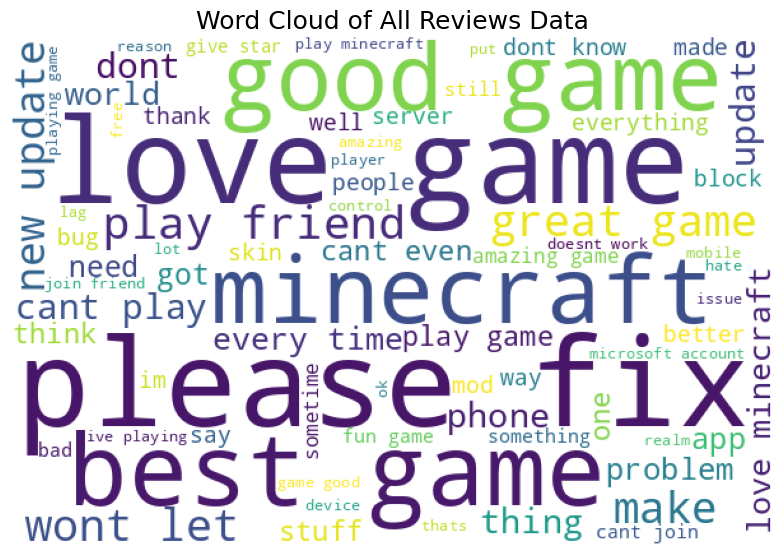

In [38]:
# Visualize Dataset to Word Cloud

visualize_word_cloud(df, option='All')

In [39]:
# Combine a token to become word
def combine_tokens(tokens):
    return ' '.join(tokens)

# Adding Sentiment label to Dataset
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [40]:
# Apply Combine Token

df['text_lemmatized'] = df['text_lemmatized'].apply(combine_tokens)
df.head()

,content,text_cleaning,text_tokens,text_stopwords,text_lemmatized
0,its okay better on pc though,its okay better on pc though,"[its, okay, better, on, pc, though]","[okay, better, pc, though]",okay well pc though
1,it wont let me download it,it wont let me download it,"[it, wont, let, me, download, it]","[wont, let, download]",will not let download
2,i love this game soo much but i want minecraft...,love this game soo much but want minecraft to...,"[love, this, game, soo, much, but, want, minec...","[love, game, soo, much, want, minecraft, creat...",love game soo much want minecraft create bedro...
3,this game is very fun ive had it for a while a...,this game is very fun ive had it for while an...,"[this, game, is, very, fun, ive, had, it, for,...","[game, fun, ive, even, though, gets, boring, s...",game fun I ve even though get boring sometimes...
4,best game ever i had a great experience also i...,best game ever had great experience also lo...,"[best, game, ever, had, great, experience, als...","[best, game, ever, great, experience, also, lo...",good game ever great experience also love add ...


In [41]:
# Adding Sentiment to Dataset

df['label'] = df['text_lemmatized'].apply(get_sentiment)
df = df[['text_lemmatized', 'label']]
df.head()

,text_lemmatized,label
0,okay well pc though,positive
1,will not let download,neutral
2,love game soo much want minecraft create bedro...,positive
3,game fun I ve even though get boring sometimes...,negative
4,good game ever great experience also love add ...,positive


In [42]:
# Calculate the number of each label class

label_counts = df['label'].value_counts()
print(label_counts)

df.to_csv(prep_dataset)

label
positive    57655
negative    41333
neutral     27771
Name: count, dtype: int64


### Balancing

In [43]:
# Read Prepared Dataset

prep_df = pd.read_csv(prep_dataset)
prep_df.head()

,Unnamed: 0,text_lemmatized,label
0,0,okay well pc though,positive
1,1,will not let download,neutral
2,2,love game soo much want minecraft create bedro...,positive
3,3,game fun I ve even though get boring sometimes...,negative
4,4,good game ever great experience also love add ...,positive


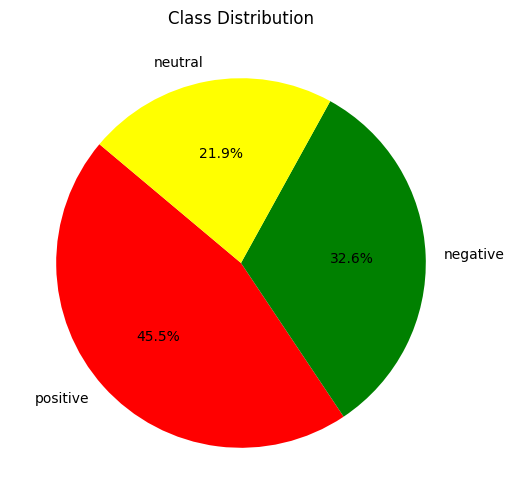

In [44]:
# Class Distribution before balancing

pie_chart(prep_df)

In [45]:
# Balacing Dataset

prep_df = balancing_dataset(prep_df)

label distribution before dropped: label
positive    57655
negative    41333
neutral     27771
Name: count, dtype: int64
label distribution after dropped: label
positive    57655
negative    41333
neutral     27771
Name: count, dtype: int64
label
positive    53896
negative    37817
neutral     18577
Name: count, dtype: int64
qty 1st label: positive
qty 2st label: 37817
qty label Dropped: 16079


In [46]:
# Dataset After Balancing

print('Balance Dataset Qty: ', prep_df['text_lemmatized'].count())

Balance Dataset Qty:  94211


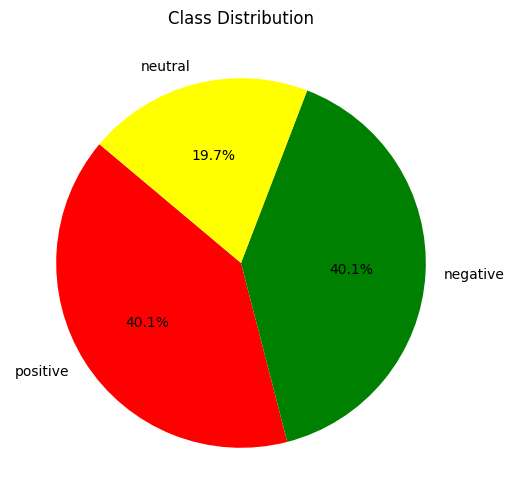

In [47]:
# Class Distribution after balancing

pie_chart(prep_df)

# Save Dataset
prep_df.to_csv(balance_dataset)

# Training and Inference

# TF IDF SVM

In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Load Dataset
df = pd.read_csv(balance_dataset)
df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,positive
1,3,3,game fun I ve even though get boring sometimes...,negative
2,5,5,good game ever play since first came come long...,negative
3,6,6,good nach good job ad bore bit bad rate skin a...,positive
4,9,9,great new update problem though every time ope...,positive


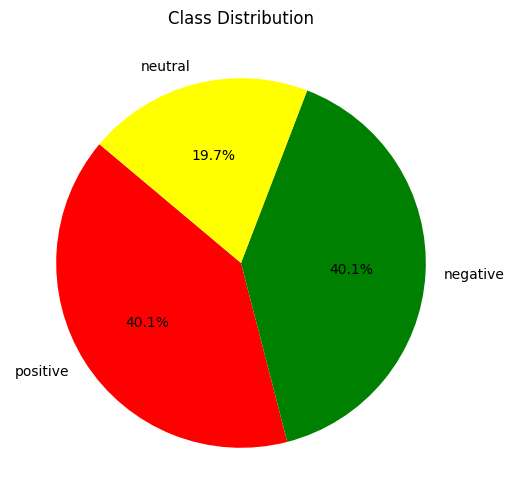

In [49]:
pie_chart(df)

In [50]:
df['text_lemmatized'].head()

,text_lemmatized
0,love game soo much want minecraft create bedro...
1,game fun I ve even though get boring sometimes...
2,good game ever play since first came come long...
3,good nach good job ad bore bit bad rate skin a...
4,great new update problem though every time ope...


In [51]:
# Converts lemmatized text to the appropriate format

df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: ' '.join(split_words(x)))
df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,positive
1,3,3,game fun I ve even though get boring sometimes...,negative
2,5,5,good game ever play since first came come long...,negative
3,6,6,good nach good job ad bore bit bad rate skin a...,positive
4,9,9,great new update problem though every time ope...,positive


In [52]:
# convert labels to numeric format

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,2
1,3,3,game fun I ve even though get boring sometimes...,0
2,5,5,good game ever play since first came come long...,0
3,6,6,good nach good job ad bore bit bad rate skin a...,2
4,9,9,great new update problem though every time ope...,2


In [53]:
# spliting data

X = df['text_lemmatized']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75368,) (18843,) (75368,) (18843,)


In [54]:
# feature extraction TF-IDF

vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(X_train_tfidf.shape, X_test_tfidf.shape)

(75368, 35062) (18843, 35062)


In [55]:
# training an SVM model with a linear kernel and 'balanced' class weights

svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)

SVC(class_weight='balanced', kernel='linear')

In [56]:
# make predictions with training data

y_train_pred = svm_model.predict(X_train_tfidf)
print("Train Data:")
print(classification_report(y_train, y_train_pred, target_names=label_encoder.classes_))

Train Data:
              precision    recall  f1-score   support

    negative       0.96      0.96      0.96     30289
     neutral       0.95      0.97      0.96     14901
    positive       0.97      0.96      0.96     30178

    accuracy                           0.96     75368
   macro avg       0.96      0.96      0.96     75368
weighted avg       0.96      0.96      0.96     75368



In [57]:
# make predictions with test data

y_test_pred = svm_model.predict(X_test_tfidf)
print("Test Data:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

Test Data:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94      7528
     neutral       0.93      0.96      0.95      3676
    positive       0.95      0.93      0.94      7639

    accuracy                           0.94     18843
   macro avg       0.94      0.95      0.94     18843
weighted avg       0.94      0.94      0.94     18843



In [58]:
# Fuction to Inference SVM Models

def analyze_user_input(text, vectorizer, model, label_encoder):
    # user input and feature extraction with TF-IDF
    text_tfidf = vectorizer.transform([text])

    # predict
    prediction = model.predict(text_tfidf)

    # change the predicted class to the original label
    predicted_label = label_encoder.inverse_transform(prediction)

    predicted_sentiment = predicted_label[0]
    print(f"The Sentiment of this text : {predicted_sentiment}")

In [59]:
# Function To Inference Tensorflow Models

def preprocess_and_predict(text, tokenizer, maxlen, model_dir, label_encoder):
    # load Models
    print('Input Text:', text)
    best_model = load_model(model_dir)

    # Preproccess Text
    tokens = tokenizer.texts_to_sequences([text])
    tokens_padded = pad_sequences(tokens, maxlen=maxlen)

    # Predict Text
    prediction = best_model.predict(tokens_padded)
    predicted_class = np.argmax(prediction, axis=1)

    # Convert Prediction Score to Text
    predicted_label = label_encoder.inverse_transform(predicted_class)
    print('Model Predictions:', predicted_label[0])

In [60]:
# Text to test All Model
positive_text = 'this game is really good'
neutral_text = 'think need to fix'
negative_text = 'this game suck'

## Inference SVM Models

In [61]:
# Positive Text
analyze_user_input(positive_text, vectorizer, svm_model, label_encoder)

The Sentiment of this text : positive


In [62]:
# Neutral Text
analyze_user_input(neutral_text, vectorizer, svm_model, label_encoder)

The Sentiment of this text : neutral


In [63]:
# Negative Text
analyze_user_input(negative_text, vectorizer, svm_model, label_encoder)

The Sentiment of this text : negative


 # GloVe Bidirectional LSTM

In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# load dataset
df = pd.read_csv(balance_dataset)
df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,positive
1,3,3,game fun I ve even though get boring sometimes...,negative
2,5,5,good game ever play since first came come long...,negative
3,6,6,good nach good job ad bore bit bad rate skin a...,positive
4,9,9,great new update problem though every time ope...,positive


In [65]:
# combine tokens into 1 sentence
df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: ' '.join(split_words(x)))
df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,positive
1,3,3,game fun I ve even though get boring sometimes...,negative
2,5,5,good game ever play since first came come long...,negative
3,6,6,good nach good job ad bore bit bad rate skin a...,positive
4,9,9,great new update problem though every time ope...,positive


In [66]:
# convert labels to numeric format
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,2
1,3,3,game fun I ve even though get boring sometimes...,0
2,5,5,good game ever play since first came come long...,0
3,6,6,good nach good job ad bore bit bad rate skin a...,2
4,9,9,great new update problem though every time ope...,2


In [67]:
# split data
X = df['text_lemmatized']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75368,) (18843,) (75368,) (18843,)


In [68]:
# Reading embedding GloVe
embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Total {len(embeddings_index)} word vectors.')

Total 400000 word vectors.


In [69]:
# using tokenizer for text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# converts text to a word index sequence
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# padding sequences
maxlen = 184
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen)

# Store word information
word_index = tokenizer.word_index
print(f'found {len(word_index)} unique tokens.')

found 35077 unique tokens.


In [70]:
# creating embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f'Embedding matrix shape: {embedding_matrix.shape}')

Embedding matrix shape: (35078, 100)


In [71]:
# calculate class weights for class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

# converting labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

In [72]:
# building LSTM models
model_glove_bidirectionals = Sequential([
    Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=False),
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(units=128)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

# setup optimizer, loss, and metrics to measure accuracy
model_glove_bidirectionals.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
model_glove_bidirectionals.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       3,507,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,507,800 (13.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,507,800 (13.38 MB)

In [73]:
# callback
model_lstm_save = 'minecraft_best_lstm_model.keras'
checkpoint = ModelCheckpoint(model_lstm_save, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
devices = '/device:GPU:0'

# Using Nvidia 4060 Mobile to Train Models
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [74]:
# train model
with tf.device(devices):
  result_glove_bidirectionals = model_glove_bidirectionals.fit(
      X_train_padded,
      y_train_one_hot,
      epochs=50,
      batch_size=32,
      validation_split=0.2,
      class_weight=class_weights_dict,
      callbacks=[checkpoint, early_stopping]
    )

Epoch 1/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 109s 55ms/step - accuracy: 0.6670 - loss: 0.7765 - val_accuracy: 0.8528 - val_loss: 0.3936
Epoch 2/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 106s 56ms/step - accuracy: 0.8516 - loss: 0.3944 - val_accuracy: 0.8675 - val_loss: 0.3623
Epoch 3/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 103s 55ms/step - accuracy: 0.8883 - loss: 0.3073 - val_accuracy: 0.9166 - val_loss: 0.2636
Epoch 4/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.9091 - loss: 0.2601 - val_accuracy: 0.9271 - val_loss: 0.2248
Epoch 5/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 103s 55ms/step - accuracy: 0.9215 - loss: 0.2166 - val_accuracy: 0.9302 - val_loss: 0.2104
Epoch 6/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 104s 55ms/step - accuracy: 0.9276 - loss: 0.2015 - val_accuracy: 0.9276 - val_loss: 0.2141
Epoch 7/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 105s 56ms/step - accuracy: 0.9372 - loss: 0.1763 - val_accuracy: 0.9408 - val_loss: 0.1882
Epoch 8/50
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 102s 54ms/step - accuracy: 

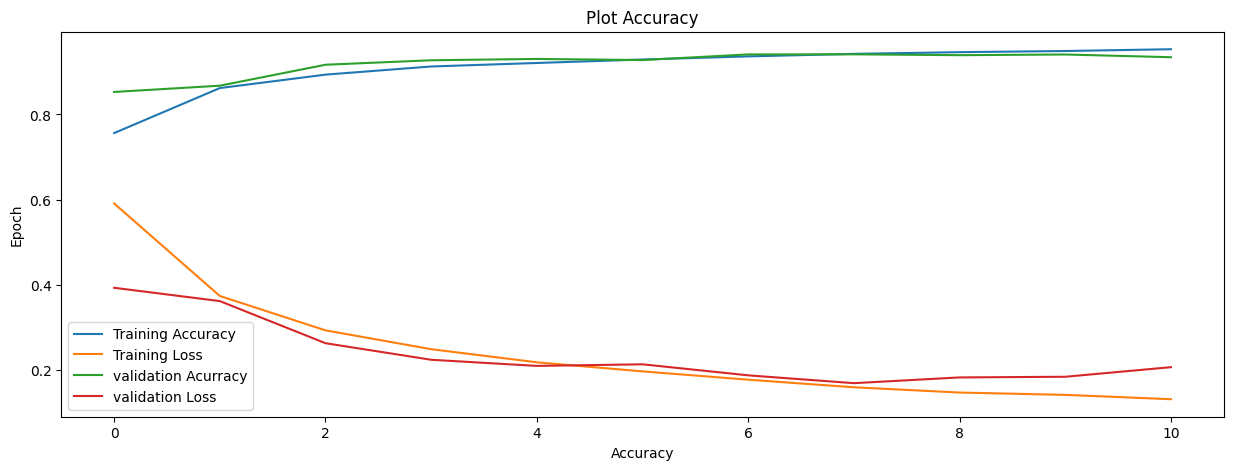

In [75]:
plot_training_model(result_glove_bidirectionals)

In [76]:
# Load best model
best_model = load_model(model_lstm_save)

# Predict with Train Data
y_train_pred = best_model.predict(X_train_padded)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_classes = np.argmax(y_train_one_hot, axis=1)

print("Train Data:")
print(classification_report(y_train_classes, y_train_pred_classes, target_names=label_encoder.classes_))

2356/2356 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step
Train Data:
              precision    recall  f1-score   support

    negative       0.95      0.96      0.95     30289
     neutral       0.95      0.98      0.96     14901
    positive       0.97      0.94      0.95     30178

    accuracy                           0.96     75368
   macro avg       0.96      0.96      0.96     75368
weighted avg       0.96      0.96      0.96     75368



In [77]:
# Predict with Test Data
y_test_pred = best_model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("Test Data:")
print(classification_report(y_test_classes, y_test_pred_classes, target_names=label_encoder.classes_))

589/589 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step
Test Data:
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94      7528
     neutral       0.94      0.97      0.96      3676
    positive       0.96      0.93      0.94      7639

    accuracy                           0.95     18843
   macro avg       0.95      0.95      0.95     18843
weighted avg       0.95      0.95      0.95     18843



## Inference Models Glove Bidirectional LSTM

In [78]:
# Positive Text
preprocess_and_predict(positive_text, tokenizer, maxlen, model_lstm_save, label_encoder)

Input Text: this game is really good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Model Predictions: positive


In [79]:
# Neutral Text
preprocess_and_predict(neutral_text, tokenizer, maxlen, model_lstm_save, label_encoder)

Input Text: think need to fix
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Model Predictions: neutral


In [80]:
# Negative Text
preprocess_and_predict(negative_text, tokenizer, maxlen, model_lstm_save, label_encoder)

Input Text: this game suck
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Model Predictions: negative


# Word2Vec LSTM

In [81]:
import pandas as pd
import numpy as np
import time
import gensim
import datetime
import tensorboard as tb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from gensim.models import Word2Vec
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

In [82]:
# Reading Clean Dataset
df = pd.read_csv(balance_dataset)
df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,positive
1,3,3,game fun I ve even though get boring sometimes...,negative
2,5,5,good game ever play since first came come long...,negative
3,6,6,good nach good job ad bore bit bad rate skin a...,positive
4,9,9,great new update problem though every time ope...,positive


In [83]:
# combine tokens into 1 word
df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: ' '.join(split_words(x)))
df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,positive
1,3,3,game fun I ve even though get boring sometimes...,negative
2,5,5,good game ever play since first came come long...,negative
3,6,6,good nach good job ad bore bit bad rate skin a...,positive
4,9,9,great new update problem though every time ope...,positive


In [84]:
# Convert label into Numeric Format
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

,Unnamed: 0.1,Unnamed: 0,text_lemmatized,label
0,2,2,love game soo much want minecraft create bedro...,2
1,3,3,game fun I ve even though get boring sometimes...,0
2,5,5,good game ever play since first came come long...,0
3,6,6,good nach good job ad bore bit bad rate skin a...,2
4,9,9,great new update problem though every time ope...,2


In [85]:
# Split Dataset
X = df['text_lemmatized']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(65947,) (28264,) (65947,) (28264,)


In [86]:
# Use Tokenizer to Teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert Text Into Squences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding Sequences
maxlen = max(len(seq) for seq in X_train_sequences + X_test_sequences)
print(f'Maximum sequence length: {maxlen}')
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} Unique Token.')

Maximum sequence length: 282
Found 32107 Unique Token.


In [87]:
sentences = [sentence.split() for sentence in X_train]

# Training model Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [88]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

print(f'Embedding matrix shape: {embedding_matrix.shape}')

Embedding matrix shape: (32108, 100)


In [89]:
# Training Model Word2Vec
sentences = [sentence.split() for sentence in X_train]
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# create embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert Label to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

In [90]:
# Create Models
model_word2vec = Sequential([
    Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=False),
    LSTM(units=128, return_sequences=True),
    Dropout(0.5),
    BatchNormalization(),
    LSTM(units=128),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

model_word2vec.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       3,210,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,210,800 (12.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,210,800 (12.25 MB)

In [91]:
adam = Adam(learning_rate=0.001)
model_word2vec.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

word2vec_checkpoint = 'word2vec_lstm_model_minecraft_checkpoint.keras'
word2vec_save = 'word2vec_lstm_model_minecraft.keras'
log_dir = 'logs/fit/'+ datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
logs_save = 'Train-BLPM-Sentiment-Analysis-Log.csv'

In [92]:
# # callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
model_checkpoint = ModelCheckpoint(word2vec_save, monitor='val_loss', save_best_only=True, mode='min')

file_writer = tf.summary.create_file_writer('/logs')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
saveLog = tf.keras.callbacks.CSVLogger(logs_save, separator=',', append=False)
tcc = time.perf_counter()

In [93]:
# Train Models

with tf.device(devices):
  tcc = time.perf_counter()
  result_word2vec =  model_word2vec.fit(
      X_train_padded, y_train_one_hot,
      epochs=30,
      batch_size=64,
      validation_split=0.3,
      class_weight=class_weights_dict,
      callbacks=[early_stopping, reduce_lr, model_checkpoint, saveLog, tensorboard_callback]
  )

model_word2vec.save(word2vec_save)

toc = time.perf_counter()
print('Training Done')

Epoch 1/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.6183 - loss: 0.8740 - val_accuracy: 0.7775 - val_loss: 0.5341 - learning_rate: 0.0010
Epoch 2/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.8038 - loss: 0.4815 - val_accuracy: 0.8487 - val_loss: 0.3938 - learning_rate: 0.0010
Epoch 3/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.8426 - loss: 0.3961 - val_accuracy: 0.6103 - val_loss: 1.2925 - learning_rate: 0.0010
Epoch 4/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.8643 - loss: 0.3541 - val_accuracy: 0.8821 - val_loss: 0.3308 - learning_rate: 0.0010
Epoch 5/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.8741 - loss: 0.3323 - val_accuracy: 0.8822 - val_loss: 0.3217 - learning_rate: 0.0010
Epoch 6/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.8836 - loss: 0.3082 - val_accuracy: 0.8893 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 7/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.8904 - l

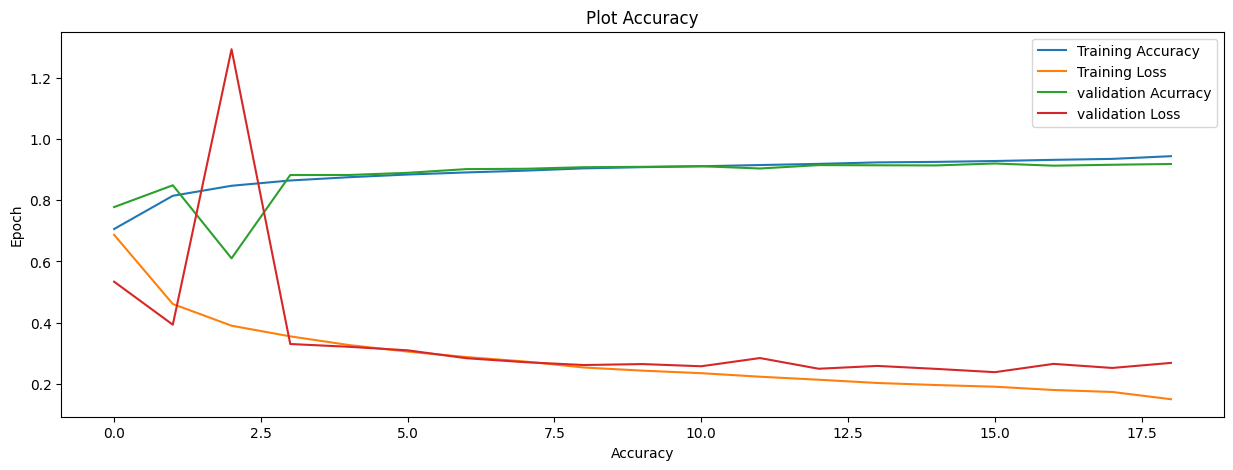

In [94]:
plot_training_model(result_word2vec)

In [95]:
# Predict with Training Data
y_train_pred_model_word2vec = model_word2vec.predict(X_train_padded)
y_train_pred_classes_model_word2vec = np.argmax(y_train_pred_model_word2vec, axis=1)
y_train_classes = np.argmax(y_train_one_hot, axis=1)

print("Train Data")
print(classification_report(y_train_classes, y_train_pred_classes_model_word2vec))

2061/2061 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step
Train Data
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     26553
           1       0.92      0.97      0.95     13045
           2       0.95      0.93      0.94     26349

    accuracy                           0.94     65947
   macro avg       0.94      0.95      0.94     65947
weighted avg       0.94      0.94      0.94     65947



In [96]:
# Predict with Test Data
y_test_pred_model_word2vec = model_word2vec.predict(X_test_padded)
y_test_pred_classes_model_word2vec = np.argmax(y_test_pred_model_word2vec, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("Test Data")
print(classification_report(y_test_classes, y_test_pred_classes_model_word2vec))

884/884 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step
Test Data
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     11264
           1       0.91      0.96      0.93      5532
           2       0.92      0.91      0.92     11468

    accuracy                           0.92     28264
   macro avg       0.92      0.93      0.92     28264
weighted avg       0.92      0.92      0.92     28264



## Inference Models Word2vec

In [97]:
preprocess_and_predict(positive_text, tokenizer, maxlen, word2vec_save, label_encoder)

Input Text: this game is really good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Model Predictions: positive


In [98]:
preprocess_and_predict(neutral_text, tokenizer, maxlen, word2vec_save, label_encoder)

Input Text: think need to fix
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Model Predictions: neutral


In [99]:
preprocess_and_predict(negative_text, tokenizer, maxlen, word2vec_save, label_encoder)

Input Text: this game suck
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Model Predictions: negative
